dataset adress : https:www.kaggle.com/datasets/saurabhshahane/mnist-for-object-detection                   (https://www.kaggle.com/datasets/saurabhshahane/mnist-for-object-detection)

In [77]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as f
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
import glob as glob
from PIL import Image
import pandas as pd 
import torchvision.models as models

In [56]:
path='C:/Users/Amir/Desktop/mnist object localization/mnist_detection/'
train_image_list=glob.glob(path+'train/images/*.*')
train_label_list= glob.glob(path+'train/labels/*.*')
test_image_list=glob.glob(path+'test/images/*.*')
test_label_list= glob.glob(path+'test/labels/*.*')


In [57]:
print(len(train_image_list))
print(len(train_label_list))
print(len(test_image_list))
print(len(test_label_list))

10000
10000
1000
1000


In [58]:
train_image_list[0:10]

['C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\0.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\10.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\100.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1000.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1001.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1002.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1003.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1004.png',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/images\\1005.png']

In [59]:
train_label_list[:10]

['C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\0.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\10.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\100.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1000.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1001.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1002.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1003.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1004.txt',
 'C:/Users/Amir/Desktop/mnist object localization/mnist_detection/train/labels\\1005.txt']

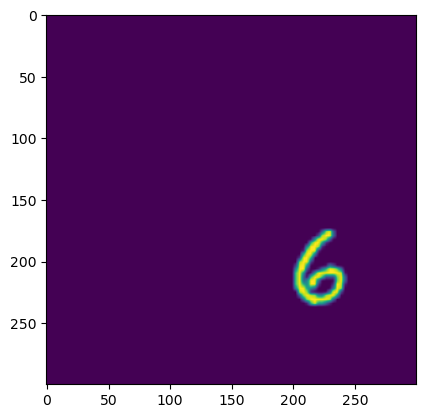

In [60]:
index=3 
img=Image.open(train_image_list[index])
plt.imshow(img)

In [61]:
bbox=pd.read_csv(train_label_list[index])
bbox

,label,xmin,ymin,xmax,ymax
0,6,200,174,245,237


In [62]:
bbox=pd.read_csv(train_label_list[index]).values[0]
bbox

array([  6, 200, 174, 245, 237], dtype=int64)

In [63]:
type(bbox)

numpy.ndarray

In [64]:
bbox=torch.from_numpy(bbox)
print(type(bbox))
bbox

<class 'torch.Tensor'>


tensor([  6, 200, 174, 245, 237])

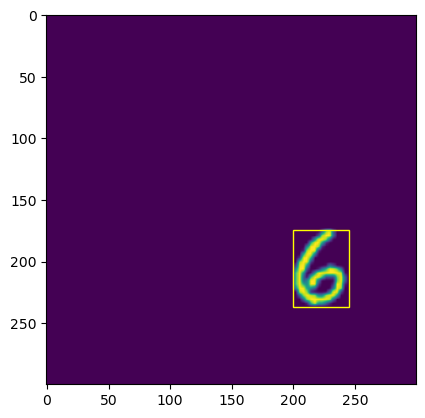

In [65]:
rect=plt.Rectangle((bbox[1],bbox[2]),bbox[3]-bbox[1],bbox[4]-bbox[2],color='yellow',fill=False)
plt.imshow(img)
plt.gca().add_patch(rect)

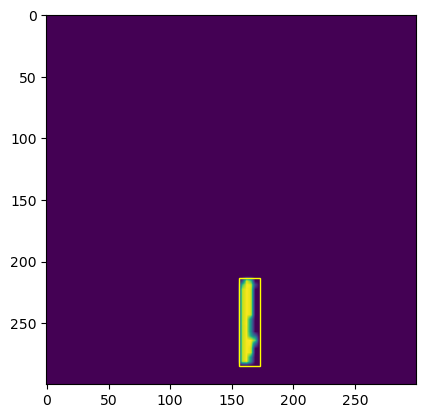

In [66]:
def draw_bbox (indx):
    index=indx 
    img=Image.open(train_image_list[index])
    bbox=pd.read_csv(train_label_list[index]).values[0]
    rect=plt.Rectangle((bbox[1],bbox[2]),bbox[3]-bbox[1],bbox[4]-bbox[2],color='yellow',fill=False)
    plt.imshow(img)
    plt.gca().add_patch(rect)

draw_bbox(87)

Normalize the bounding box according the size 

In [67]:
print(bbox[1:])
print(img.size)
sz=229
image_resize= transforms.Resize((sz,sz))
img=image_resize(img)
print(img.size)
scale=sz/300
print(scale)
bbox_new=(bbox[1:]/300)*scale
print(bbox_new)
bbox_new=(bbox_new/scale)*229           #this is a bbox if image size is 229*229
bbox_new


tensor([200, 174, 245, 237])
(300, 300)
(229, 229)
0.7633333333333333
tensor([0.5089, 0.4427, 0.6234, 0.6030])


tensor([152.6667, 132.8200, 187.0167, 180.9100])

# make the custome dataset

In [73]:
class mnist_dataset (Dataset):
    def __init__(self,images,bbox,sz):
        self.images=images
        self.bbox=bbox
        self.sz=sz
        self.transforms=transforms.Compose([transforms.Resize((sz,sz)), transforms.ToTensor()])
                                           
    def __getitem__(self,index):
        image=self.images[index]
        image=Image.open(image)
        (w,h)=image.size
        image=self.transforms(image)
        scale=sz/w
        annotation=pd.read_csv(self.bbox[index]).values[0]
        lbl=annotation[0]
        bbox=annotation[1:]
        bbox=torch.from_numpy(bbox)
        bbox=(bbox/w)*scale
        return image,lbl,bbox,(w,h)
    
    def __len__(self):
        return len(self.images)
        


# Dataloader

In [74]:
train_ds= mnist_dataset(train_image_list,train_label_list ,sz=229)
test_ds= mnist_dataset(test_image_list,test_label_list ,sz=229)
train_dl=DataLoader(dataset= train_ds,batch_size=16 , shuffle=True)
test_dl=DataLoader(dataset= test_ds,batch_size=16 , shuffle=True)

In [71]:
train_dl

In [76]:
images,labels,bboxs,_=next(iter(train_dl))
print(len(images))
print(labels)
print(bboxs)

16
tensor([0, 9, 8, 6, 7, 7, 2, 5, 6, 8, 3, 4, 2, 7, 5, 2])
tensor([[0.1450, 0.6997, 0.1959, 0.7506],
        [0.1069, 0.4758, 0.1527, 0.5496],
        [0.5216, 0.0534, 0.5700, 0.1298],
        [0.0967, 0.6743, 0.1450, 0.7226],
        [0.3257, 0.4020, 0.4020, 0.5242],
        [0.3639, 0.0687, 0.4656, 0.1959],
        [0.5038, 0.2595, 0.6005, 0.3562],
        [0.2723, 0.3689, 0.3842, 0.4707],
        [0.6285, 0.1196, 0.7379, 0.2417],
        [0.3435, 0.1857, 0.4834, 0.3588],
        [0.1323, 0.4249, 0.2188, 0.5318],
        [0.2265, 0.0636, 0.3588, 0.2112],
        [0.3918, 0.3969, 0.5165, 0.5216],
        [0.1323, 0.2214, 0.2723, 0.3766],
        [0.0407, 0.3410, 0.1628, 0.4733],
        [0.1425, 0.5369, 0.2468, 0.6641]])


# Use pretrained model : Resnet34

In [86]:
model=models.resnet34(pretrained=True)
model

C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Amir/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:21<00:00, 4.02MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

in Conv1  3 channel must be changed into 1 and in the last fc layer out_features must be 10+4


In [100]:
class custommodel (nn.Module):
    def __init__(self,num_classes=10):
        super (custommodel,self).__init__()
        self.num_classes=num_classes
        model=models.resnet34(pretrained=True)
        model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        in_feature= model.fc.in_features
        model.fc=nn.Linear(in_features=in_feature, out_features=num_classes+4, bias=True)
        self.model=model
    
    def forward(self,x):
        out=self.model(x)
        score=out[:,:self.num_classes]
        bbox=out[:,self.num_classes:]
        return score,torch.sigmoid(bbox)
    
    

# loss function

In [101]:
class customloss (nn.Module):
    def __init__(self):
        super (customloss,self).__init__()
        self.crossEntropy=nn.CrossEntropyLoss()
        self.mse=nn.MSELoss(reduction='sum')

    def forward (self, score,labl,pbbox,bbox):
        classloss= self.crossEntropy(score,labl)
        l1=self.mse(pbbox[:, 0],bbox[:,0])
        l2=self.mse(pbbox[:, 1],bbox[:,1])
        l3=self.mse(pbbox[:, 2],bbox[:,2])
        l4=self.mse(pbbox[:, 3],bbox[:,3])
        return classloss+l1+l2+l3+l4

    

In [102]:
model=custommodel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion=customloss()
model=model.to(device)
criterion=criterion.to(device)
optimiser= optim.Adam(params=model.parameters(), lr=0.00001)

C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
epochs=15

for i in range(epochs):
    sumloss=0
    for idx,(images,lbl,bbox,_) in enumerate(train_dl):
        images=images.to(device)
        lbl=lbl.to(device)
        bbox=bbox.to(device)
        score,pbbox=model(images)
        loss=criterion(score,lbl,pbbox,bbox)
        sumloss+=loss
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if idx%50==0:
            print(f'loss in idx {idx+1} equal to {loss}')
    print(f'loss in epoch {i+1} equal to {sumloss}')



loss in idx 1 equal to 0.03530145063996315
loss in idx 51 equal to 0.0468609556555748
loss in idx 101 equal to 0.03174975514411926
loss in idx 151 equal to 0.027855155989527702
loss in idx 201 equal to 0.013866892084479332
loss in idx 251 equal to 0.03527258336544037
loss in idx 301 equal to 0.02278492972254753
loss in idx 351 equal to 0.053643546998500824
loss in idx 401 equal to 0.026533950120210648
loss in idx 451 equal to 0.018828729167580605
loss in idx 501 equal to 0.013879956677556038
loss in idx 551 equal to 0.015592046082019806
loss in idx 601 equal to 0.0887739434838295
loss in epoch 1 equal to 23.20036506652832
loss in idx 1 equal to 0.008039820939302444
loss in idx 51 equal to 0.010689272545278072
loss in idx 101 equal to 0.0159706212580204
loss in idx 151 equal to 0.057472534477710724
loss in idx 201 equal to 0.016183020547032356
loss in idx 251 equal to 0.018163569271564484
loss in idx 301 equal to 0.015567711554467678
loss in idx 351 equal to 0.02801182121038437
loss in 

In [119]:
images,_,_,size=next(iter(train_dl))
print(images.size())
images=images.to(device)
score,pbbox=model(images)

torch.Size([16, 1, 229, 229])


In [120]:
print(score.size())
score[3]

torch.Size([16, 10])


tensor([-2.4359, -2.8387,  9.7186, -2.1000, -1.9444, -1.9049, -2.6660, -1.5450,
        -0.6060, -2.4623], device='cuda:0', grad_fn=<SelectBackward0>)

In [121]:
print(pbbox.size())
pbbox[3]

torch.Size([16, 4])


tensor([0.5329, 0.2720, 0.5852, 0.3259], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [122]:
pbbox=(pbbox/scale)*229
pbbox[3]

tensor([159.8781,  81.5920, 175.5604,  97.7705], device='cuda:0',
       grad_fn=<SelectBackward0>)

# Tensorboard

In [123]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter(log_dir='log/mnist')

for i in range (len(images)): 
    writer.add_image_with_boxes(tag='images',
                                img_tensor=images[i],
                                box_tensor=pbbox[i].unsqueeze(0),
                                global_step=i,
                                labels=str(score[i].argmax().item()))
writer.flush()
writer.close()



# Test dataloader

In [124]:
writer=SummaryWriter(log_dir='log2/mnist')
images,_,_,size=next(iter(test_dl))
print(images.size())
images=images.to(device)
score,pbbox=model(images)
pbbox=(pbbox/scale)*229

for i in range (len(images)): 
    writer.add_image_with_boxes(tag='test_images',
                                img_tensor=images[i],
                                box_tensor=pbbox[i].unsqueeze(0),
                                global_step=i,
                                labels=str(score[i].argmax().item()))
writer.flush()
writer.close()

torch.Size([16, 1, 229, 229])
